In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
df = pd.read_csv('CreditScoring_final.csv')
df

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,5,owner,18,29,married,0,fixed,45,142,6000,3000,450,1678
1,ok,12,owner,36,56,married,0,fixed,75,205,5500,1950,275,300
2,ok,2,parents,36,19,married,0,fixed,35,162,4000,100,400,570
3,ok,10,owner,48,50,married,0,freelance,45,128,11500,0,500,1195
4,ok,2,parents,36,34,married,0,fixed,60,400,9800,0,900,1316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3113,ok,20,other,60,39,married,0,fixed,60,119,0,0,1300,1639
3114,default,2,priv,60,53,married,0,fixed,75,85,7000,0,1050,1172
3115,ok,8,owner,48,52,married,0,fixed,60,105,3500,0,1000,1887
3116,ok,2,owner,36,30,married,0,fixed,45,350,4000,0,800,1800


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3118 entries, 0 to 3117
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   status     3117 non-null   object
 1   seniority  3118 non-null   int64 
 2   home       3114 non-null   object
 3   time       3118 non-null   int64 
 4   age        3118 non-null   int64 
 5   marital    3118 non-null   object
 6   records    3118 non-null   int64 
 7   job        3117 non-null   object
 8   expenses   3118 non-null   int64 
 9   income     3118 non-null   int64 
 10  assets     3118 non-null   int64 
 11  debt       3118 non-null   int64 
 12  amount     3118 non-null   int64 
 13  price      3118 non-null   int64 
dtypes: int64(10), object(4)
memory usage: 341.2+ KB


In [5]:
df.describe().astype(int)

,seniority,time,age,records,expenses,income,assets,debt,amount,price
count,3118,3118,3118,3118,3118,3118,3118,3118,3118,3118
mean,8,46,37,0,55,769853,1224097,449342,1038,1462
std,8,14,11,0,19,8740952,10973301,6686778,476,640
min,0,6,18,0,35,0,0,0,100,105
25%,2,36,28,0,35,80,0,0,700,1114
50%,5,48,36,0,51,120,3500,0,1000,1400
75%,12,60,45,0,73,166,6000,0,1300,1685
max,47,72,68,1,180,99999999,99999999,99999999,5000,11140


In [6]:
df['status'].isna().sum()

np.int64(1)

In [7]:
df = df[df.status.notnull()]

In [8]:
df.loc[:, 'status'] = (df.loc[:, 'status'].map({'ok': 1, 'default': 0})).astype(int)
df['status'] = df['status'].astype(int)

C:\Users\Home\AppData\Local\Temp\ipykernel_6568\3760350911.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['status'] = df['status'].astype(int)


In [9]:
df.status.info()

<class 'pandas.core.series.Series'>
Index: 3117 entries, 0 to 3117
Series name: status
Non-Null Count  Dtype
--------------  -----
3117 non-null   int64
dtypes: int64(1)
memory usage: 48.7 KB


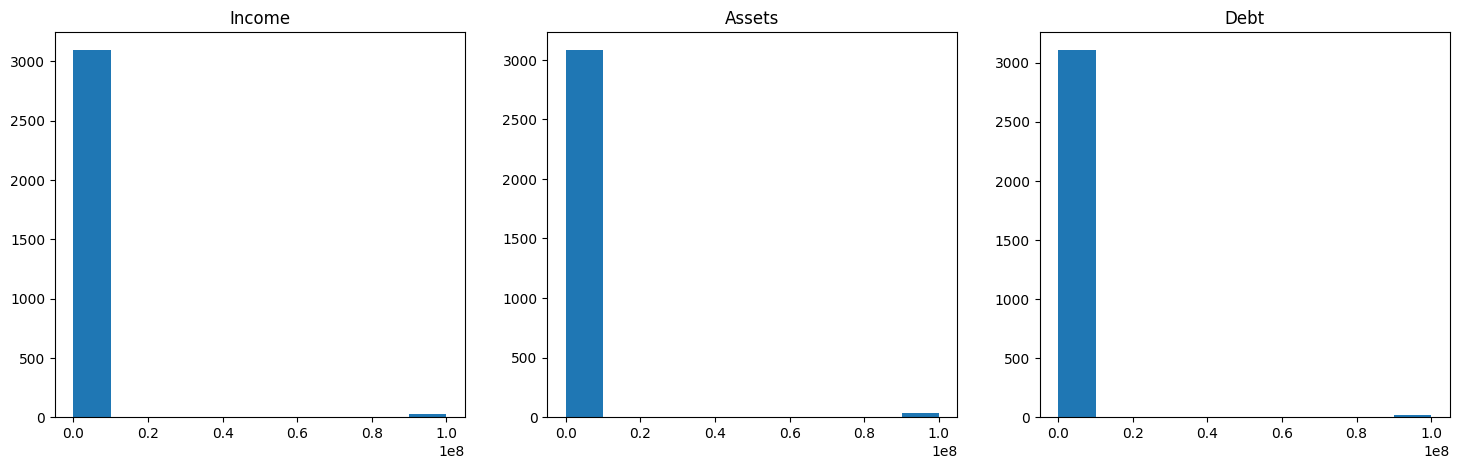

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].hist(df.income)
axs[0].title.set_text('Income')

axs[1].hist(df.assets)
axs[1].title.set_text('Assets')

axs[2].hist(df.debt)
axs[2].title.set_text('Debt')

plt.show()

In [11]:
print(df.loc[:, ['income', 'assets', 'debt']].replace({99999999: np.nan}).describe().astype(int))
df[['income', 'assets', 'debt']] = df[['income', 'assets', 'debt']].replace({99999999: np.nan})

       income  assets   debt
count    3093    3079   3103
mean      130    5434    338
std        87   11311   1249
min         0       0      0
25%        80       0      0
50%       119    3000      0
75%       165    6000      0
max       959  300000  30000


C:\Users\Home\AppData\Local\Temp\ipykernel_6568\2022427867.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['income', 'assets', 'debt']] = df[['income', 'assets', 'debt']].replace({99999999: np.nan})


<Axes: xlabel='assets', ylabel='count'>

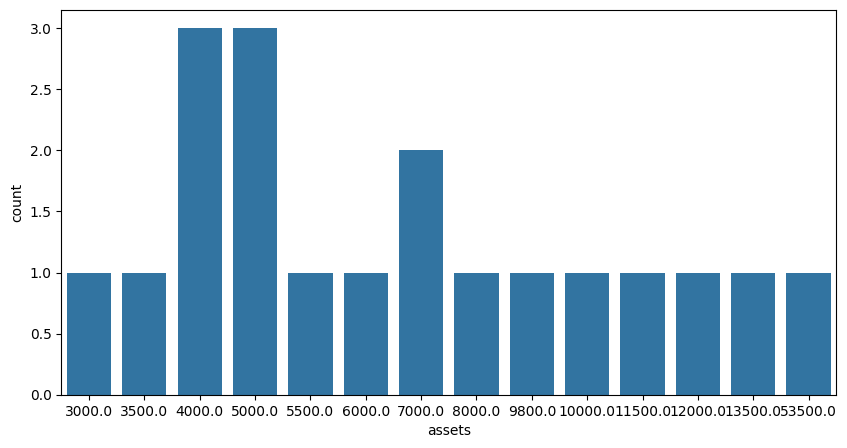

In [12]:
plt.figure(figsize=(10, 5))
sns.countplot(x='assets', data=df[df['assets'] != 0].iloc[:20, :])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3117 entries, 0 to 3117
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   status     3117 non-null   int64  
 1   seniority  3117 non-null   int64  
 2   home       3113 non-null   object 
 3   time       3117 non-null   int64  
 4   age        3117 non-null   int64  
 5   marital    3117 non-null   object 
 6   records    3117 non-null   int64  
 7   job        3116 non-null   object 
 8   expenses   3117 non-null   int64  
 9   income     3093 non-null   float64
 10  assets     3079 non-null   float64
 11  debt       3103 non-null   float64
 12  amount     3117 non-null   int64  
 13  price      3117 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 365.3+ KB


In [14]:
df = pd.get_dummies(df, columns=['home', 'marital', 'job'])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3117 entries, 0 to 3117
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status             3117 non-null   int64  
 1   seniority          3117 non-null   int64  
 2   time               3117 non-null   int64  
 3   age                3117 non-null   int64  
 4   records            3117 non-null   int64  
 5   expenses           3117 non-null   int64  
 6   income             3093 non-null   float64
 7   assets             3079 non-null   float64
 8   debt               3103 non-null   float64
 9   amount             3117 non-null   int64  
 10  price              3117 non-null   int64  
 11  home_ignore        3117 non-null   bool   
 12  home_other         3117 non-null   bool   
 13  home_owner         3117 non-null   bool   
 14  home_parents       3117 non-null   bool   
 15  home_priv          3117 non-null   bool   
 16  home_rent          3117 non-n

In [16]:
df.describe().astype(int)

,status,seniority,time,age,records,expenses,income,assets,debt,amount,price
count,3117,3117,3117,3117,3117,3117,3093,3079,3103,3117,3117
mean,0,8,46,37,0,55,130,5434,338,1037,1461
std,0,8,14,11,0,19,87,11311,1249,476,640
min,0,0,6,18,0,35,0,0,0,100,105
25%,0,2,36,28,0,35,80,0,0,700,1114
50%,1,5,48,36,0,51,119,3000,0,1000,1400
75%,1,12,60,45,0,73,165,6000,0,1300,1684
max,1,47,72,68,1,180,959,300000,30000,5000,11140


In [17]:
print(df.assets.count())
print(df.status.count() - df.assets.isna().sum())

3079
3079


In [18]:
print(df.status.value_counts())

status
1    2236
0     881
Name: count, dtype: int64


In [19]:
pd.set_option('display.max_columns', 50)
df

,status,seniority,time,age,records,expenses,income,assets,debt,amount,price,home_ignore,home_other,home_owner,home_parents,home_priv,home_rent,marital_divorced,marital_married,marital_separated,marital_single,marital_widow,job_fixed,job_freelance,job_others,job_partime
0,1,5,18,29,0,45,142.0,6000.0,3000.0,450,1678,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False
1,1,12,36,56,0,75,205.0,5500.0,1950.0,275,300,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False
2,1,2,36,19,0,35,162.0,4000.0,100.0,400,570,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False
3,1,10,48,50,0,45,128.0,11500.0,0.0,500,1195,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False
4,1,2,36,34,0,60,400.0,9800.0,0.0,900,1316,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3113,1,20,60,39,0,60,119.0,0.0,0.0,1300,1639,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False
3114,0,2,60,53,0,75,85.0,7000.0,0.0,1050,1172,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False
3115,1,8,48,52,0,60,105.0,3500.0,0.0,1000,1887,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False
3116,1,2,36,30,0,45,350.0,4000.0,0.0,800,1800,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False


In [20]:
df.isna().sum()

status                0
seniority             0
time                  0
age                   0
records               0
expenses              0
income               24
assets               38
debt                 14
amount                0
price                 0
home_ignore           0
home_other            0
home_owner            0
home_parents          0
home_priv             0
home_rent             0
marital_divorced      0
marital_married       0
marital_separated     0
marital_single        0
marital_widow         0
job_fixed             0
job_freelance         0
job_others            0
job_partime           0
dtype: int64

<Axes: >

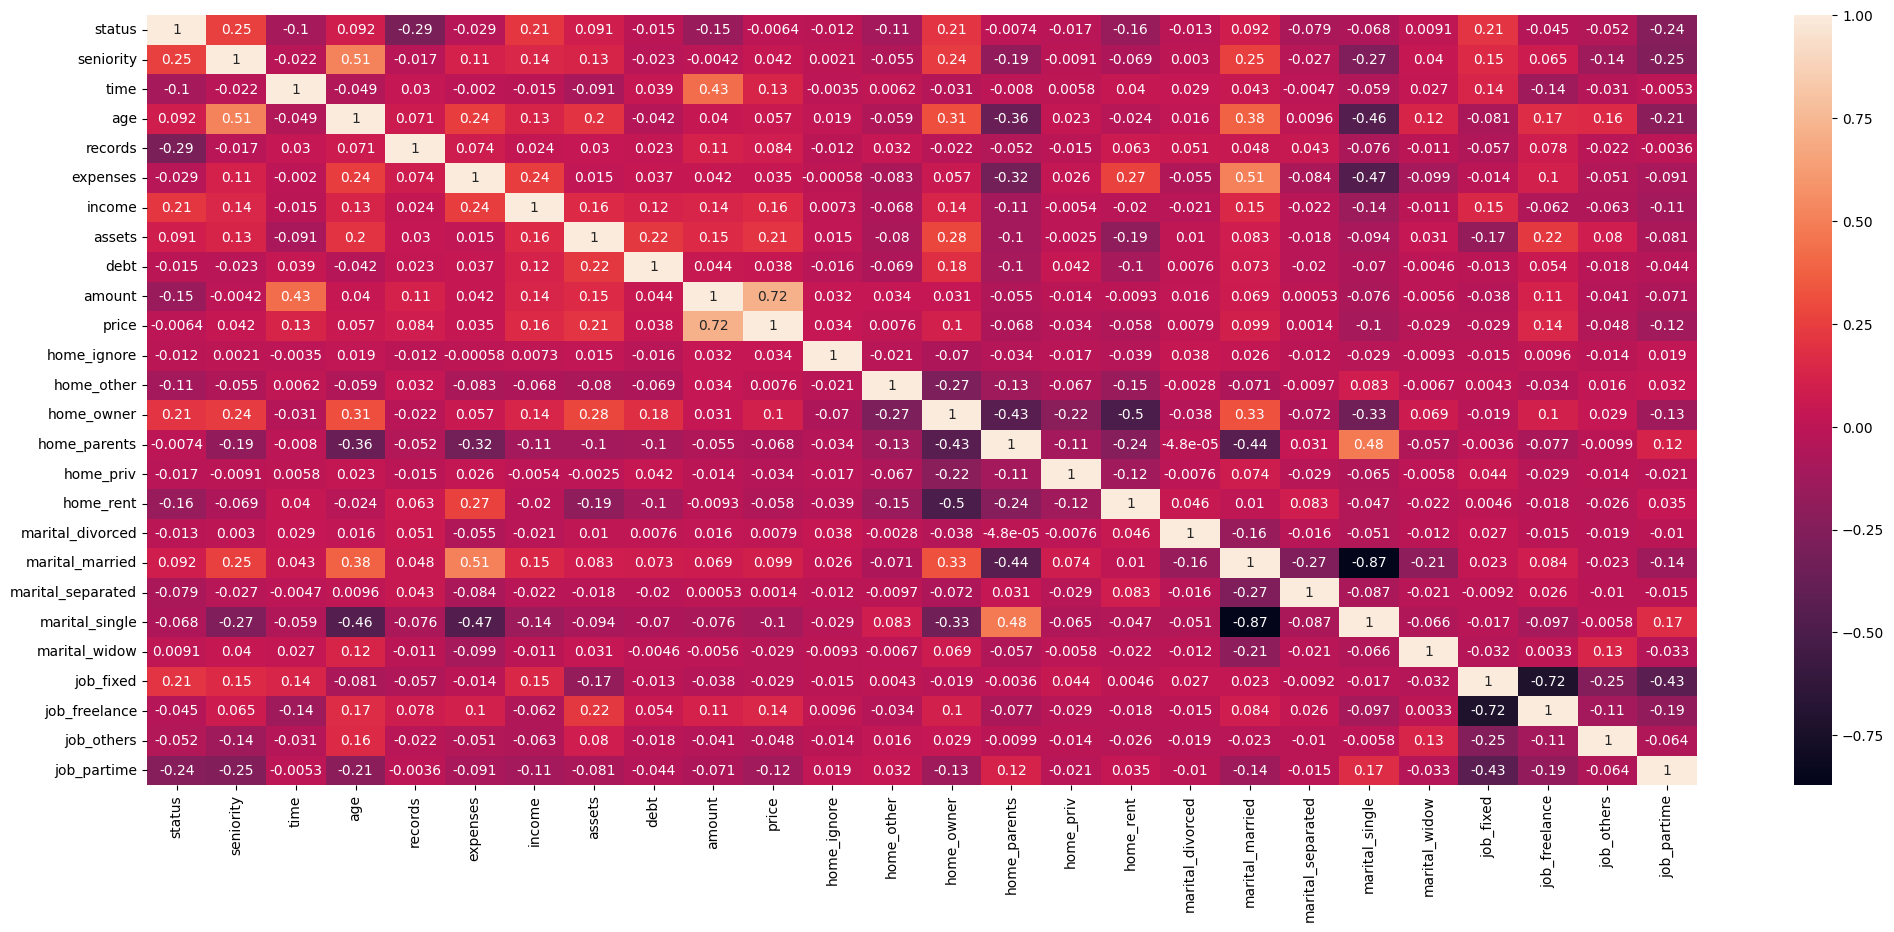

In [21]:
plt.figure(figsize=(25, 10))
sns.heatmap(data=df.corr(), annot=True)

- Corelatia intre **amount** si **price** e cea mai mare dintre toate
- **seniority** are corelatie cu coloana **status**, 0.25
- **age** are corelatie distul de mare cu **seniority**, 0.51

In [22]:
df.iloc[:, :11]

,status,seniority,time,age,records,expenses,income,assets,debt,amount,price
0,1,5,18,29,0,45,142.0,6000.0,3000.0,450,1678
1,1,12,36,56,0,75,205.0,5500.0,1950.0,275,300
2,1,2,36,19,0,35,162.0,4000.0,100.0,400,570
3,1,10,48,50,0,45,128.0,11500.0,0.0,500,1195
4,1,2,36,34,0,60,400.0,9800.0,0.0,900,1316
...,...,...,...,...,...,...,...,...,...,...,...
3113,1,20,60,39,0,60,119.0,0.0,0.0,1300,1639
3114,0,2,60,53,0,75,85.0,7000.0,0.0,1050,1172
3115,1,8,48,52,0,60,105.0,3500.0,0.0,1000,1887
3116,1,2,36,30,0,45,350.0,4000.0,0.0,800,1800


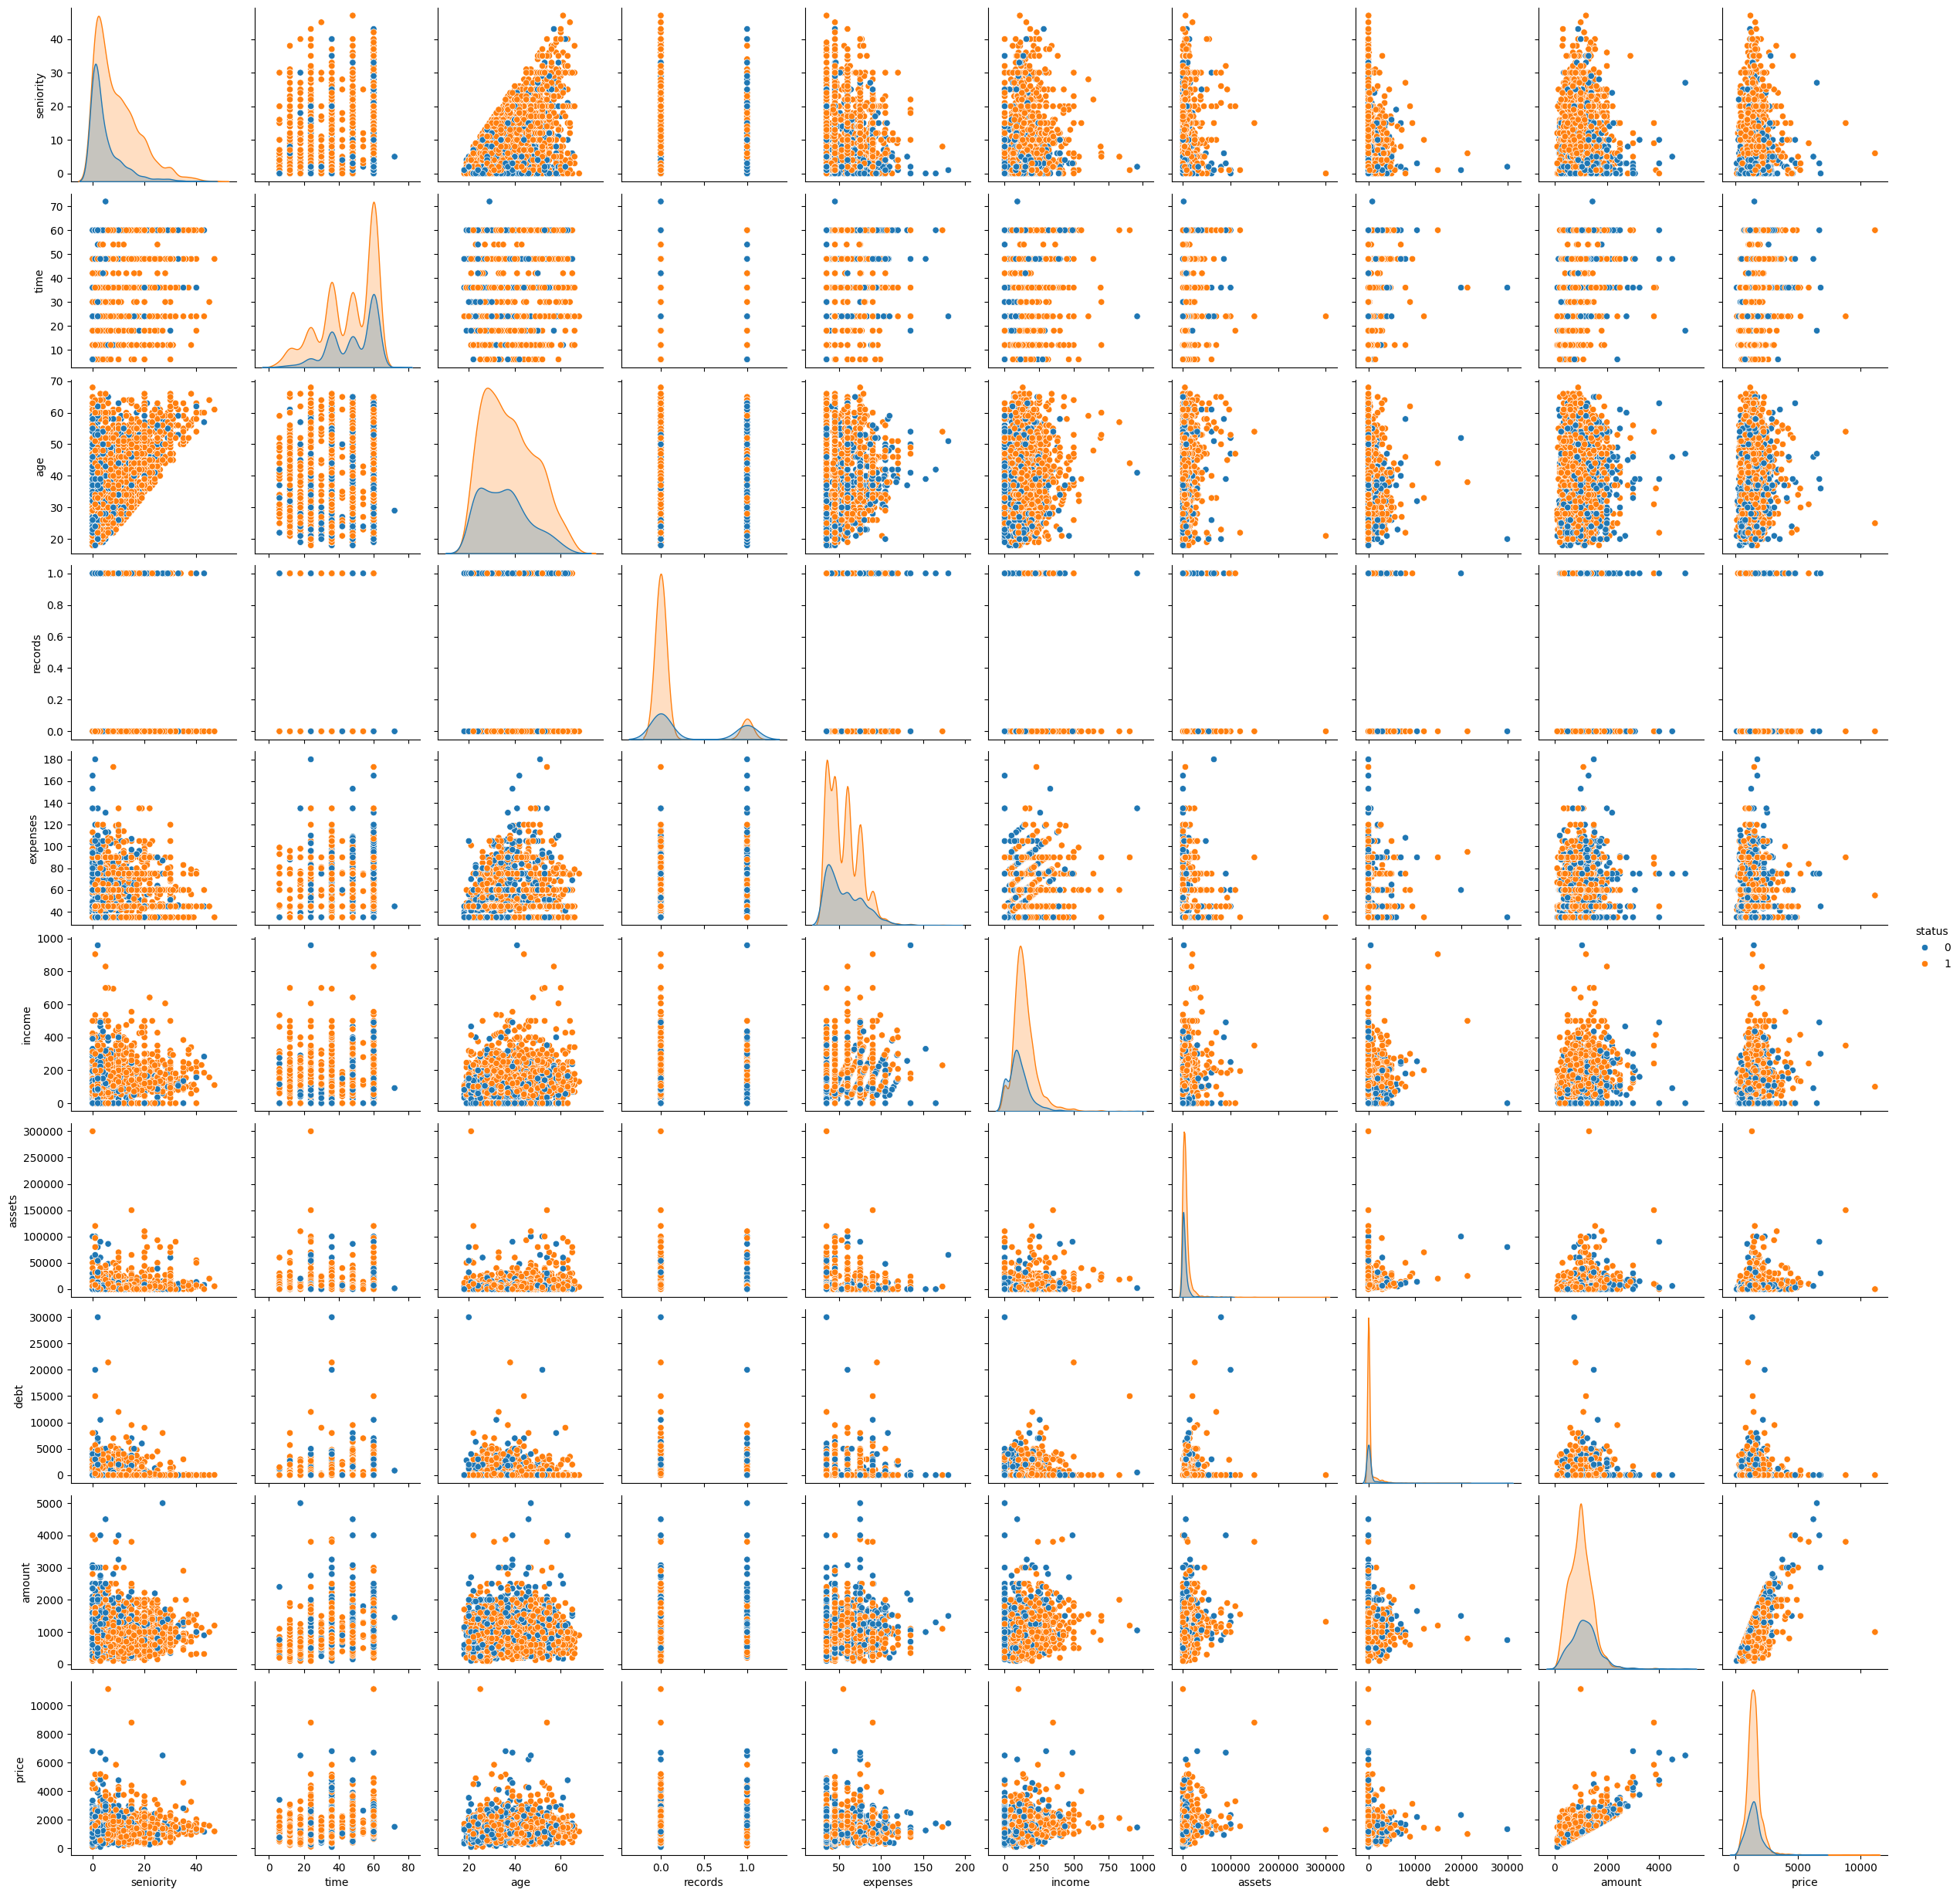

In [24]:
sns.pairplot(df.iloc[:, :11], hue='status')